Before you run the code, make sure the runtime type is GPU (Runtime -> Change runtime type -> GPU).

The following notebook has been adapted from "Adversarial examples and human-ML alignment (MIT BCS tutorial)" by Shibani Santurkar and Dimitris Tsipras.

In [1]:
%%capture 
!pip install robustness
!git clone https://gitlab.com/msatkiewicz/robustness_exercises.git code
!mv code/*.py .
!gdown "https://drive.google.com/uc?export=download&id=1n0EfV1rULXD4mB0Pu598XqRYg9TRuhq9"
!unzip tutorial.zip
!mv tutorial/* .

In [2]:
!ls

code  data  models  sample_data  tutorial  tutorial.zip  utils.py


In [3]:
try: # set up path
    import google.colab, sys, torch
    if not torch.cuda.is_available():
        print("Please change runtime type to include a GPU.")  
except:
    pass

In [4]:
# Import basic libraries needed for the exercise (numpy, matplotlib, and torch)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange
import torch
from torch import nn, optim
import torchvision
import torchvision.transforms as transforms

# We also use the robustness library (https://robustness.readthedocs.io/en/latest/) for some 
# convenient functionality.
from robustness.tools.vis_tools import show_image_row
from robustness.tools.helpers import AverageMeter
from robustness import imagenet_models
from cox import store
import dill

import utils 

sns.set_style('darkgrid')
%matplotlib inline
%load_ext autoreload
%autoreload 2

%load_ext tensorboard

In [5]:
DEFAULT_NUM = 10 # how many images display in the row

# Setup

### Load datasets

For our experiments (except Ex. II), we will use a subset of the ImageNet dataset from the ILSVRC challenge. ImageNet is a 1000 class dataset, that has played an important role in developing and evaluating deep learning models.

In [6]:
# Create a loader to access our subset of ImageNet (one example per class). In addition to the loader, we also need to obtain a
# normalization function. This is because standard deep networks are typically trained 
# on normalized images, so we need to apply the same normalization for adversarial examples. Finally,
# we also get a label map, that tells us what class a corresponding numeric value corresponds
# to.
loaders_IN, normalization_function_IN, label_map_IN = utils.get_custom_imagenet(data_aug=False)

train_loader_IN, test_loader_IN = loaders_IN

==> Preparing dataset imagenet..


We can visualize some ImageNet samples, along with their labels, as follows

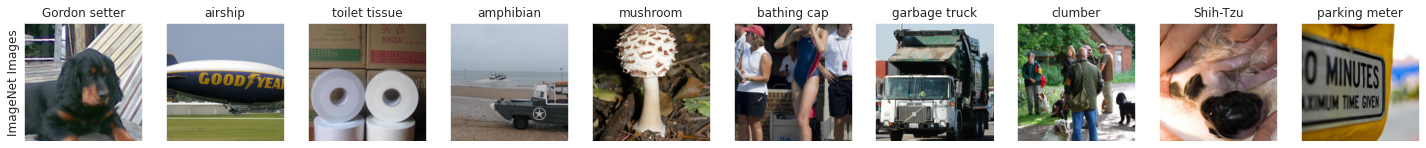

In [7]:
img_IN, targ_IN = next(iter(train_loader_IN))

num = DEFAULT_NUM
show_image_row([img_IN[:num]],
              ["ImageNet Images"],
              tlist=[[label_map_IN[int(t)] for t in targ_IN]])

## Load model

Next, we need a model to play with! PyTorch provides access to a large range of pre-trained deep networks (for a full list, see <https://pytorch.org/docs/stable/torchvision/models.html>). For example, we can load a ResNet18 using the following code.

In [8]:
std_model = torchvision.models.resnet18(pretrained=True).cuda()
std_model.eval()
pass

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


# Exercise I: Adversarial examples

Since their discovery, adversarial examples have been one of the most extensively studied phenomena in deep learning. Adversarial perturbations are *imperceptible* (non-random) perturbations that can be added to any input image so as to cause a standard (highly accurate) classifier to misclassify the modified input (or classify it as an adversarially chosen class). 

*Finding adversarial examples:* The idea is pretty simple: given a target class (t), we want to find a perturbation ($\delta'$) that when added to the input (x) maximizes the likelihood of the target class. At the same time, we want the perturbation to be small or lie within some pre-defined perturbation set: for example in a tiny L2 ball around the image. Basically, we want to find a $\delta'$ such that

$\delta' = argmin_{||\delta||_2 \leq \epsilon} L(x + \delta, t; \theta)$


To find a perturbation that minimizes the objective (maximizes likelihood) while remaining in a bounded set, we use projected gradient descent PGD (see <https://arxiv.org/abs/1706.06083> for more). 

### Try it yourself! 

First choose a target class for every input. (Note that you have a batch of inputs, so you could try different targets for different inputs.)

In [9]:
TARGET_IN = 1
print(f"Target class: {label_map_IN[TARGET_IN]}")
target_class_IN = TARGET_IN * torch.ones_like(targ_IN)

Target class: goldfish


Next, we'll implement `L2PGD` that transforms images to adversarial examples. You have to **fill in the missing line**.

There are a couple of parameters that you need to be wary of:
1. eps: maximum size of the perturbation in terms of L2 norm. For e.g., eps=2 implies that $||\delta||_2 \leq 2$
2. Nsteps: number of (projected) gradient descent to perform
3. step_size: size of each step of (projected) gradient descent

After you've implemented the function, try varying these parameters and see what happens.

In [10]:
def L2PGD(mod, im, targ, normalization, step_size, Nsteps,
        eps=None, targeted=True, custom_loss=None, use_tqdm=False):
    '''
    Compute L2 adversarial examples for given model.
    Args:
        mod: model
        im (tensor): batch of images
        targ (tensor): batch of labels
        normalization (function): normalization function to be applied on inputs
        step_size (float): optimization step size
        Nsteps (int): number of optimization steps
        eps (float): radius of L2 ball
        targeted (bool): True if we want to maximize loss, else False
        custom_loss (function): custom loss function to employ (optional)
        
    Returns:
        x: batch of adversarial examples for input images
    ''' 
    assert targ is not None
    prev_training = bool(mod.training)
    mod.eval()

    sign = -1 if targeted else 1
        
    it = iter(range(Nsteps))
    if use_tqdm:
        it = tqdm(iter(range(Nsteps)), total=Nsteps) 
    
    x = im.detach()
    im_dims = len(x.shape) - 1 # how many dimensions are there for single image
    
    for i in it:    
        x = x.clone().detach().requires_grad_(True)
        g, loss = utils.get_gradient(mod, x, targ, normalization, 
                               custom_loss=custom_loss)
        
        if use_tqdm:
            it.set_description(f'Loss: {loss}')
        
        with torch.no_grad():
            
            # Compute gradient step 
            g_norm = torch.norm(g.view(g.shape[0], -1), dim=1).view(-1, *([1]*im_dims))
            scaled_g = g / (g_norm + 1e-10)
            # x += ... DONE fill this line
            x += sign * scaled_g * step_size
            
            # Project back to L2 eps ball
            if eps is not None:
                diff = x - im
                diff = diff.renorm(p=2, dim=0, maxnorm=eps)
                x = im + diff
            x = torch.clamp(x, 0, 1)
    
    if prev_training:
        mod.train()

    return x

In [11]:
# Create adversarial examples
adv_ex_IN = L2PGD(std_model, img_IN, target_class_IN, normalization_function_IN,
                       step_size=0.5, Nsteps=20, 
                       eps=1.25, targeted=True, use_tqdm=True)

  0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Loss: 0.018266450613737106: 100%|██████████| 20/20 [00:04<00:00,  4.31it/s]


### Evaluate model predictions at perturbed inputs

To see if our attack was successful, we will now evaluate model predictions at the perturbed inputs. We would expect the predicted label to match the `target_class` used above, if we succeeded.

In [13]:
pred_label_IN = utils.get_predictions(std_model, 
                                      adv_ex_IN, 
                                      normalization_function_IN)
pred_label_IN

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')

### Visualize adversarial examples

We now inspect the original (unperturbed) inputs (*top*), along with the corresponding adversarial examples (*bottom*). We also look at what the model predicts for each row of images.

Does the attack succeed? Do the adversarial examples look different from the original inputs?

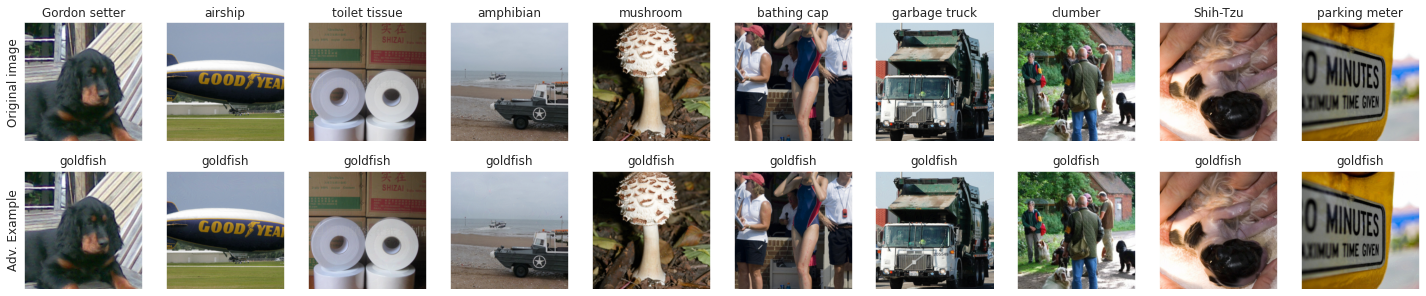

In [14]:
num = DEFAULT_NUM
show_image_row([img_IN[:num], adv_ex_IN[:num]], 
               ['Original image', 'Adv. Example'],
               tlist=[[label_map_IN[int(t)] for t in label] \
                      for label in [targ_IN, pred_label_IN]])

# Exercise II: Are adversarial perturbations meaningless?

In this experiment, we will revisit the cause underlying the brittleness of models to adversarial perturbations. In particular, we will examine if adversarial perturbations indeed correspond to meaningless sensitivities (or bugs) in the model.

For computational efficiency, we will perform this experiment using linear classifiers trained on a binary subset of the CIFAR-10 dataset. 


Let's start by loading the dataset and looking at some of its samples.

In [15]:
%%time
loaders_BIN, normalization_function_BIN, label_map_BIN = utils.get_binary_dataset(
    batch_size=100, data_aug=False, targets=[0, 3], per_target=5000, random=False
)

train_loader_BIN, test_loader_BIN = loaders_BIN


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
CPU times: user 16.9 s, sys: 1.58 s, total: 18.5 s
Wall time: 22.4 s


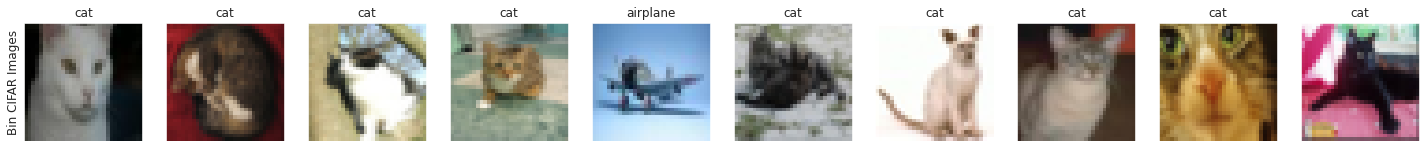

In [16]:
img_BIN, targ_BIN = next(iter(train_loader_BIN))

num = DEFAULT_NUM
show_image_row([img_BIN[:num]],
              ["Bin CIFAR Images"],
              tlist=[[label_map_BIN[int(t)] for t in targ_BIN]])

### Training a linear classifier on this classification task

As you can see, the dataset contains two classes: cats and airplanes. We will now train a very basic linear classifier on the data. First let's create some helper functions.

In [17]:
def train_loop(model, loader, optimizer, criterion, epoch="-", normalization=None):
    acc_meter = AverageMeter()
    iterator = tqdm(iter(loader), total=len(loader))
    for data, target in iterator:
        data, target = data.cuda(), target.cuda()
        model.train()
        optimizer.zero_grad()
        logits = utils.forward_pass(model, data, normalization)
        loss = criterion(logits, target)
        loss.backward()
        optimizer.step()
    
        with torch.no_grad():
            model.eval()
            val = utils.accuracy(model, data, target, normalization)
            acc_meter.update(val, data.shape[0])
            
            iterator.set_description(f"Epoch: {epoch}, Train accuracy={acc_meter.avg:.2f}")
            iterator.refresh()

            
def eval_loop(model, loader, epoch="-", normalization=None):
    acc_meter = AverageMeter()
    iterator = tqdm(iter(loader), total=len(loader))
    model.eval()
    with torch.no_grad():
        for data, target in iterator:
            data, target = data.cuda(), target.cuda()
            val = utils.accuracy(model, data, target, normalization)
            acc_meter.update(val, data.shape[0])
            
            iterator.set_description(f"Epoch: {epoch}, TEST accuracy={acc_meter.avg:.2f}")
            iterator.refresh()

We're going to train networks in several scenarios, so this function will be usefull. Fill in the missing parts.

In [18]:
def train_model(model, train_loader, test_loader, train_loop, eval_loop, step_size, epochs, normalization):
    log_iterations = 5

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=step_size)

    eval_loop(model, test_loader, normalization=normalization)

    for epoch in range(epochs):
        # DONE - fill this line
        train_loop(model, train_loader, optimizer, criterion, epoch, normalization)

        if epoch % log_iterations == 0:
            # DONE - fill this line
            eval_loop(model, test_loader, epoch, normalization)

Now let's train the model!

In [19]:
std_linear_net = utils.Linear(Nfeatures=3*32*32, Nclasses=2).cuda()

train_model(std_linear_net,
            train_loader_BIN,
            test_loader_BIN,
            train_loop,
            eval_loop,
            step_size = 0.001,
            epochs = 11,
            normalization=normalization_function_BIN
)

Epoch: 10, TEST accuracy=81.50: 100%|██████████| 20/20 [00:00<00:00, 30.64it/s]


Let's take a look at some samples from the dataset, along with their labels and model predictions.

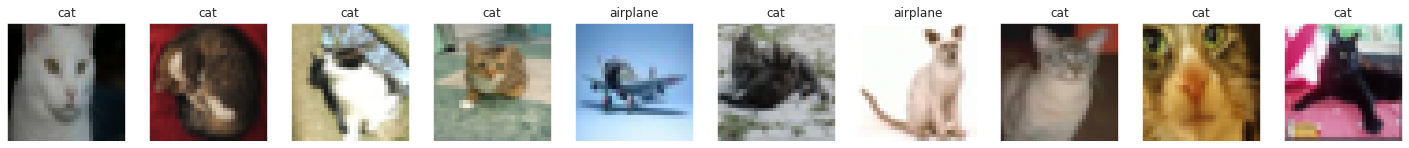

In [20]:
preds_BIN = utils.get_predictions(std_linear_net, img_BIN, normalization_function_BIN)

num = DEFAULT_NUM
show_image_row([img_BIN[:num]],
               tlist=[[label_map_BIN[int(t)] for t in preds_BIN]])

### Using adversarial examples to train models

Note that adversarial examples correspond to adding a non-random perturbation to a given input data point. Thus adversarial perturbations modify input features, albeit in an imperceptible way.

So what features do these perturbations modify? Do they just exploit meaningless sensitivities (or bugs) of the models? What happens if we train a new model solely on adversarial examples?

We will now construct a *training* dataset made of adversarial examples. Specifically, we will:

Step 1. Add adversarial perturbations to all the training set images to fool the linear classifier into flipping its prediction (i.e., classify cats as airplains and airplanes as cats).

Step 2. We will now take all the successful adversarial examples (i.e., data points that were originally classified correctly by the model, but now after they have been adversarially perturbed are classified incorrectly) and use these to make a new dataset. The image labels in this dataset will be the labels *predicted* by the model.

In [21]:
%%time
ims_BIN = []
ADV_ims_BIN = []
train_targets_BIN = []

std_linear_net.eval()
for data, target in train_loader_BIN:
    data, target = data.cuda(), target.cuda()
    
    data_adv = L2PGD(std_linear_net, data, target, normalization_function_BIN,
                       step_size=0.1, Nsteps=20, 
                       eps=1.25, targeted=False)

    ims_BIN.append(data)
    ADV_ims_BIN.append(data_adv)
    train_targets_BIN.append(target)
    
full_train_data_BIN = torch.cat(ims_BIN).cuda()
full_train_ADV_data_BIN = torch.cat(ADV_ims_BIN).cuda()
full_train_targets_BIN = torch.cat(train_targets_BIN).cuda()

CPU times: user 4.82 s, sys: 178 ms, total: 4.99 s
Wall time: 4.98 s


Let's look at how many examples we managed to fool the network on and examine some of these samples

In [22]:
full_preds_BIN = utils.get_predictions(std_linear_net, full_train_data_BIN, normalization_function_BIN)
print("% normal examples on which model is fooled:",
      f"{100 * torch.mean((~full_preds_BIN.eq(full_train_targets_BIN)).float()).item():.2f} \n")

full_ADV_preds_BIN = utils.get_predictions(std_linear_net, full_train_ADV_data_BIN, normalization_function_BIN)
print("% adv examples on which model is fooled:",
      f"{100 * torch.mean((~full_ADV_preds_BIN.eq(full_train_targets_BIN)).float()).item():.2f} \n")

% normal examples on which model is fooled: 16.34 

% adv examples on which model is fooled: 99.93 



We fooled the model on almost all examples. Therefore we won't bother filtering them.

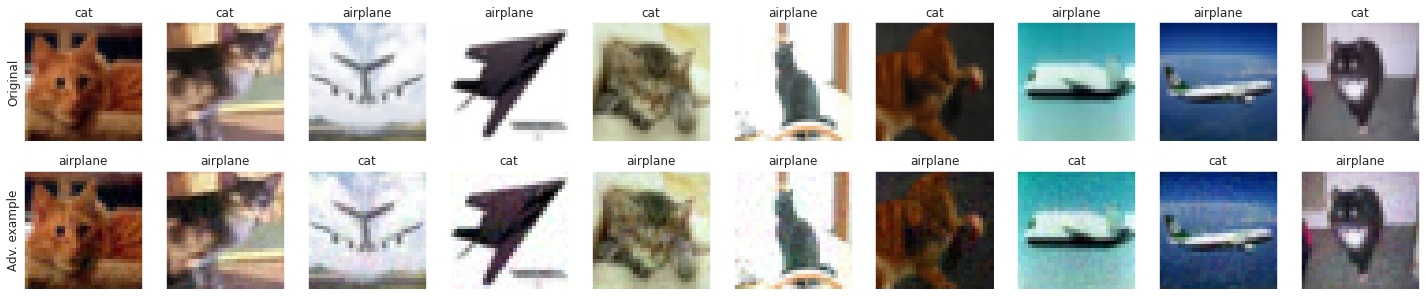

In [23]:
num = DEFAULT_NUM
show_image_row([full_train_data_BIN[:num].cpu(), full_train_ADV_data_BIN[:num].cpu()],
               ylist=["Original", "Adv. example"],
               tlist=[[label_map_BIN[int(t)] for t in full_preds_BIN[:num]], [label_map_BIN[int(t)] for t in full_ADV_preds_BIN[:num]]])

Note that in the original data, airplanes were labeled as `airplaine` and cats were labeled as `cat` (unsurprisingly). However for the adversarial examples, the model predicts the opposite/incorrect label.

We will now train a *new* model on these adversarial examples. Note crucially, that the data points are labeled based on the *predicted label* and hence the labels are flipped w.r.t. the original train/test set.

Let's look again at the training and test data
* If you, as a human, were trained on the samples in the second row in the figure above what mapping would you learn between [cats, airplanes] and labels [`cat`, `airplane`]?
* What would your accuracy on the original (unmodified) test set be?

In [24]:
flipped_train_ds = torch.utils.data.TensorDataset(full_train_ADV_data_BIN, full_ADV_preds_BIN)
flipped_train_loader = torch.utils.data.DataLoader(flipped_train_ds, batch_size=100, shuffle=True)

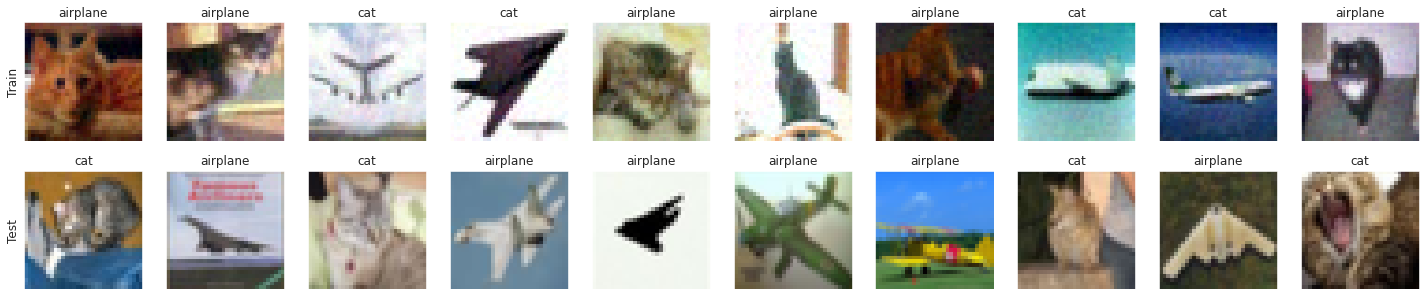

In [25]:
test_img_BIN, test_targ_BIN = next(iter(test_loader_BIN)) 

num = DEFAULT_NUM
show_image_row([full_train_ADV_data_BIN[:num].cpu(), test_img_BIN[:num]],
               ylist=["Train", "Test"],
               tlist=[[label_map_BIN[int(t)] for t in full_ADV_preds_BIN[:num]], [label_map_BIN[int(t)] for t in test_targ_BIN[:num]]])

We will now train a linear classifier from scratch on this mislabelled dataset.

In [26]:
flipped_linear_net = utils.Linear(Nfeatures=3*32*32, Nclasses=2).cuda()

train_model(flipped_linear_net,
            flipped_train_loader,
            test_loader_BIN,
            train_loop,
            eval_loop,
            step_size = 0.0001,
            epochs = 41,
            normalization=normalization_function_BIN
)

Epoch: 40, TEST accuracy=61.85: 100%|██████████| 20/20 [00:00<00:00, 26.62it/s]


The model still gets > 70% accuracy on the original, unmodified test set, despite being trained on an entirely mislabeled training set!

Let's look at the predictions of this model to be sure.

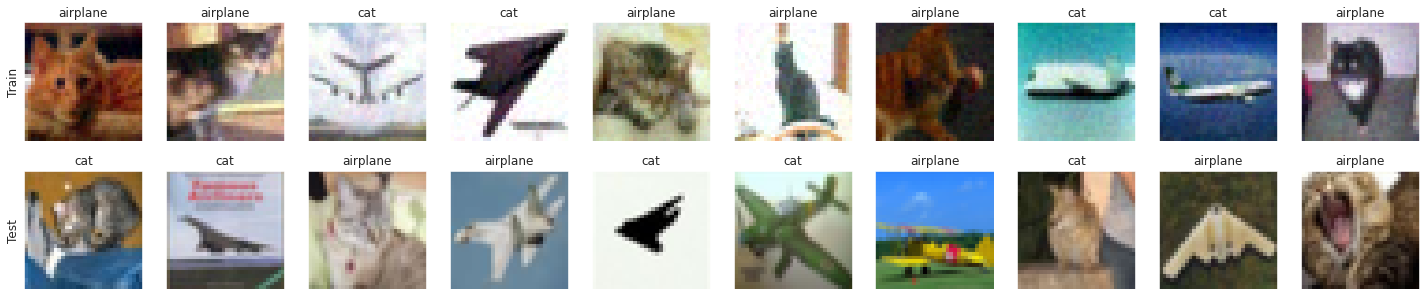

In [27]:
preds_FLIPPED = utils.get_predictions(flipped_linear_net, test_img_BIN, normalization_function_BIN)

num = DEFAULT_NUM
show_image_row([full_train_ADV_data_BIN[:num].cpu(), test_img_BIN[:num]],
               ylist=["Train", "Test"],
               tlist=[[label_map_BIN[int(t)] for t in full_ADV_preds_BIN[:num]], [label_map_BIN[int(t)] for t in preds_FLIPPED[:num]]])


So how did this happen? 

Note that all the human meaningful features, which we refer to as robust features, in these images point to the incorrect label (e.g., wings -> 1 and ears -> 0). Thus, a human trained on the dataset above would get 0% accuracy on the test set.

Since it is not possible to get non-trivial accuracy on the test set based on robust features, this must be due to the (imperceptible) features we introduced via adversarial perturbations. For instance, when we added adversarial perturbations to a cat image to make the first linear classifier think it was a plane, we must have added features that actually generalize to planes on the test set. 

Thus, adversarial examples do not correspond just to meaningless sensitivies but to well-generalizing features. We see this phenomenon occur on state-of-the-art deep nets and on multi-class datasets such as CIFAR or ImageNet. You could try to reproduce this effect there as a follow-up exercise!

# Exercise III: Gradients as model interpretations

So far, we saw that standard models rely on non-robust features for part of their performance. We will now explore how this dependence affects other properties of standard models, specifically model interpretability.

For this, we will begin by looking at one of the most natural interpretations: gradient-based saliency maps. These maps highlight which input features (pixels) the model prediction is sensitive to.

(In these experiments, we will go back to the ImageNet-trained ResNet model from Ex. I.)

### Compute and visualize gradient

In [28]:
img_IN, targ_IN = next(iter(train_loader_IN))

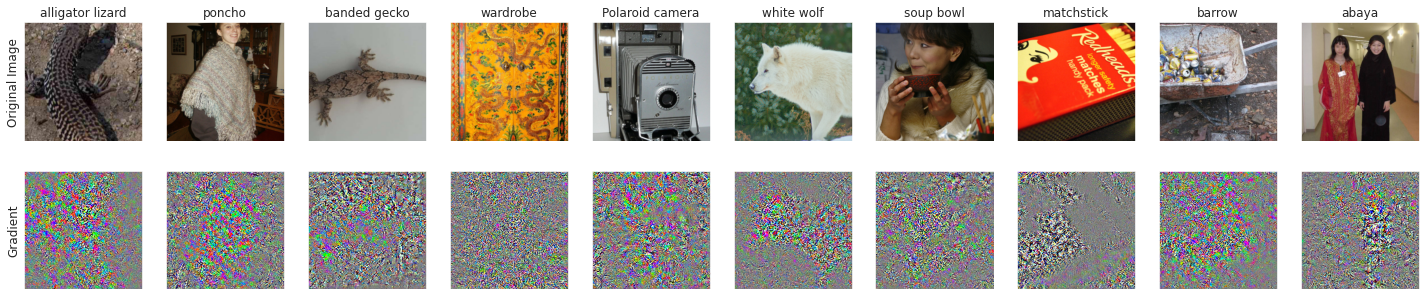

In [29]:
# We compute the gradient of the loss, with respect to the input. For every image pixel,
# the gradient tells us how the loss changes if we vary that pixel slightly.

grad_IN, _ = utils.get_gradient(std_model, img_IN, targ_IN, normalization_function_IN)

# We can then visualize the original image, along with the gradient. Note that the gradient may
# not lie within the valid pixel range ([0, 1]), so we need to rescale it using the 
# `visualize_gradient` function.

num = DEFAULT_NUM
show_image_row([img_IN[:num], utils.visualize_gradient(grad_IN)[:num]],
              ["Original Image", "Gradient"],
              tlist=[[label_map_IN[int(t)] for t in targ_IN], ["" for _ in targ_IN]])

The gradients of standard models look quite noisy and seem rather hard to interpret. Why might this be the case? Could it have something to do with non-robust features?

# Exercise IV:  Try SmoothGrad and visualize the interpretations

Fill in the following skeleton to implement SmoothGrad. Then, try using SmoothGrad to interpret a standard model

In [30]:
def smooth_grad(mod, im, targ, normalization, 
                Nsamples, stdev):
    # Instead of taking the gradient of a single image, we will take gradients
    # at a bunch of neighborhood points and average their gradients.
    
    it = tqdm(range(Nsamples), total=Nsamples)

    total_grad = 0
    for _ in it:
        # Create a noisy version of the input image
        # DONE - fill the code
        noise = torch.tensor(np.random.normal(0, stdev, im.shape), dtype=im.dtype)
        noised_im = im + noise
        # Compute gradient at noised version of the image
        grad, _ = utils.get_gradient(mod, noised_im, targ, normalization)
        total_grad += grad
    
    # Return average gradient
    return total_grad / Nsamples

In [31]:
sgrad = smooth_grad(std_model, img_IN, targ_IN, normalization_function_IN,
                    100, 0.3)

100%|██████████| 100/100 [00:30<00:00,  3.23it/s]


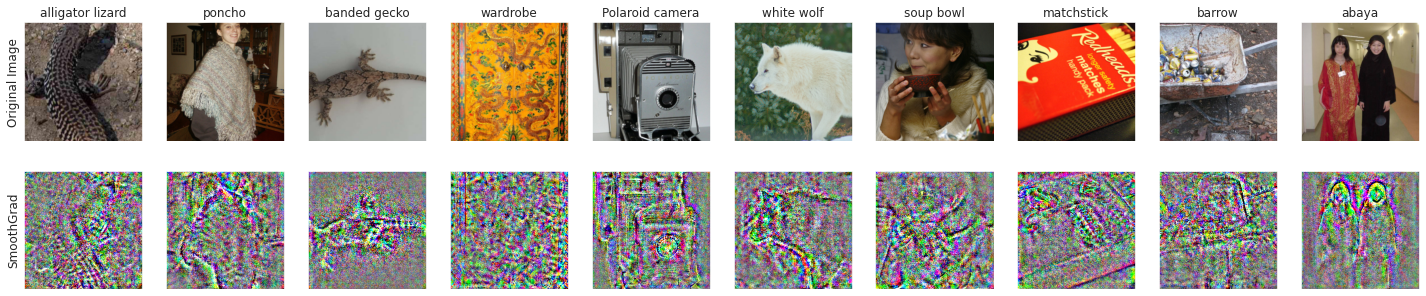

In [32]:
# We once again use the `visualize_gradient` helper to make the SmoothGrad suitable for 
# visualization.

num = DEFAULT_NUM
show_image_row([img_IN[:num], utils.visualize_gradient(sgrad)[:num]],
              ["Original Image", "SmoothGrad"],
               tlist=[[label_map_IN[int(t)] for t in targ_IN], ["" for _ in targ_IN]])

Explanations based on SmoothGrad align much better with features that we humans might use to make predictions. But what did we actually fix in smoothing the gradients? Were vanilla gradients just overly sensitive and noisy? Or did we maybe mask some  features that the models actually rely on to get cleaner interpretations?

# Exercise V: Playing with robust models

The existance of adversarial examples has also prompted a large body of research to build models that are robust to these perturbations, i.e., so-called *robust models*. One approach to get a robust model is to train against the PGD adversary: instead of minimizing the loss over training examples, we minimize the loss against adversarially perturbed training samples (obtained using PGD). We will now take a closer look at robust models.

### Loading a robust model

For our study today, we will use a pre-trained robust model. We trained this model (ResNet50) on a 9-class subset of the ImageNet dataset. (Developing good robust models for the more complex 1000 class version is still an active area of research.)

In [33]:
robust_model = utils.load_restricted_imagenet_model()
robust_model.eval()
pass

=> loading checkpoint './models/RestrictedImageNet.pt'
=> loaded checkpoint './models/RestrictedImageNet.pt' (epoch 61)


In [34]:
loaders_RIN, normalization_function_RIN, label_map_RIN = utils.get_custom_imagenet(
    restricted=True, data_aug=False, shuffle_val=True)

train_loader_RIN, test_loader_RIN = loaders_RIN

==> Preparing dataset restricted_imagenet..


### Can adversarial examples fool a robust model?

We can now try to fool the robust model using the same procedure as before. Does it succeed? Try varying the attack parameters and see what happens.

In [35]:
# Choose a target label for the attack.
TARGET_RIN = 3

print(f"Target class: {label_map_RIN[TARGET_RIN]}")

Target class: turtle


Loss: 7.97320556640625: 100%|██████████| 20/20 [00:10<00:00,  1.88it/s]


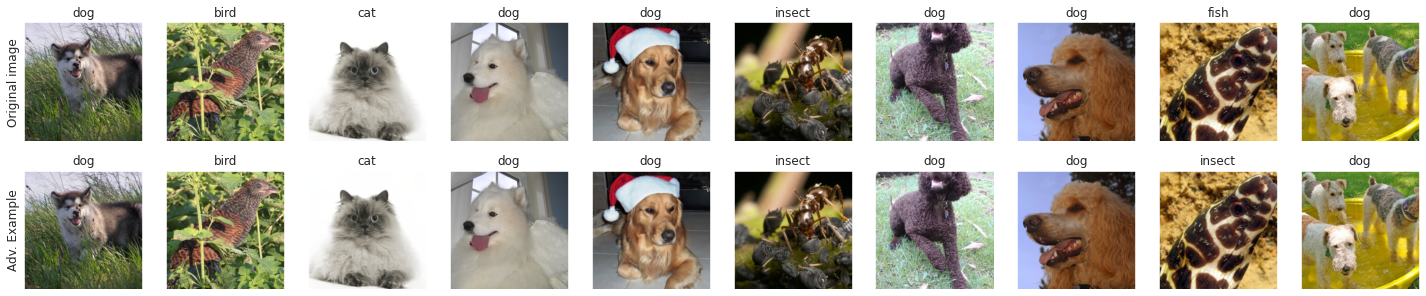

In [36]:
# Load images from the Restricted ImageNet dataset
img_RIN, targ_RIN = next(iter(test_loader_RIN))

target_class_RIN = TARGET_RIN * torch.ones_like(targ_RIN)

# Create adversarial examples
adv_ex_RIN = L2PGD(robust_model, img_RIN, target_class_RIN, normalization_function_RIN,
                       step_size=0.5, Nsteps=20, eps=1.25, targeted=True, use_tqdm=True)

# Evaluate model predictions
pred_label_RIN = utils.get_predictions(robust_model, adv_ex_RIN, normalization_function_RIN)

# Visualize adversarial examples

num = DEFAULT_NUM
show_image_row([img_RIN[:num], adv_ex_RIN[:num]], 
               ['Original image', 'Adv. Example'],
               tlist=[[label_map_RIN[int(t)] for t in label] \
                      for label in [targ_RIN, pred_label_RIN]])

### Changing the prediction of a robust model

We know that robust models are not easily fooled by adversarial examples. This tells us that one cannot change the prediction of a robust model using imperceptible L2 perturbations to the input (in contrast to standard models). How can we then modify the input to make the robust model predict a different class?

Try creating adversarial examples as before, but with a larger eps. Our hope is that by increasing the size of the perturbation set, we can find a perturbation that actually causes the model to change its prediction? What do the perturbed inputs, i.e., "*large epsilon adversarial examples*" look like?

In [39]:
strong_adv_ex_RIN = L2PGD(robust_model, img_RIN, target_class_RIN, normalization_function_RIN,
                        step_size=5, Nsteps=20, eps=100, targeted=True, use_tqdm=True)

# Evaluate model predictions
pred_label_RIN = utils.get_predictions(robust_model, strong_adv_ex_RIN, normalization_function_RIN)

Loss: 6.556508225230573e-08: 100%|██████████| 20/20 [00:10<00:00,  1.88it/s]


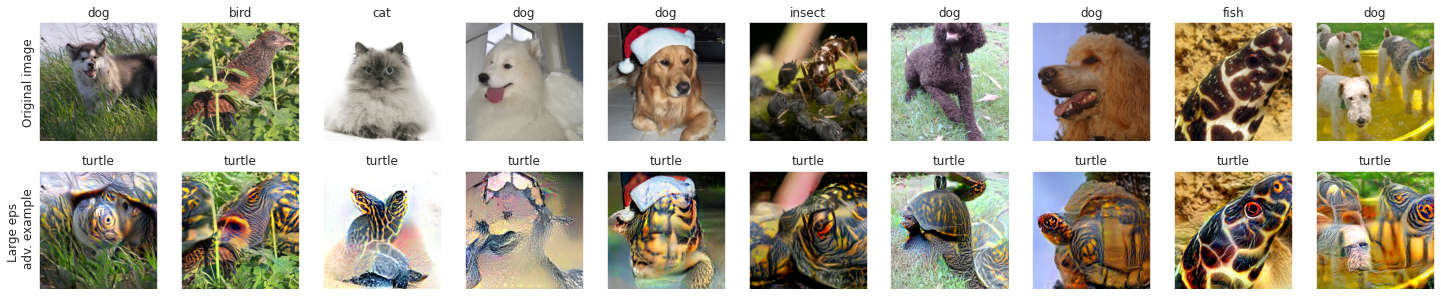

In [40]:
num = DEFAULT_NUM
show_image_row([img_RIN[:num], strong_adv_ex_RIN[:num]],
              ['Original image', 'Large eps \n adv. example'],
               tlist=[[label_map_RIN[int(t)] for t in label] \
                      for label in [targ_RIN, pred_label_RIN]])

# Exercise VI: Interpretations for robust models

Based on the previous experiment, we know that, for robust models, (a) imperceptible input changes do not change the prediction and (b) to change the prediction, we actually need to change "salient image features".

Does this mean that the features that robust models rely on are more human-aligned in a sense?

### VI.I Let's start by looking at their gradients.

What do the gradients of robust models look like? How do they compare to the gradients of a standard model and the output of SmoothGrad?

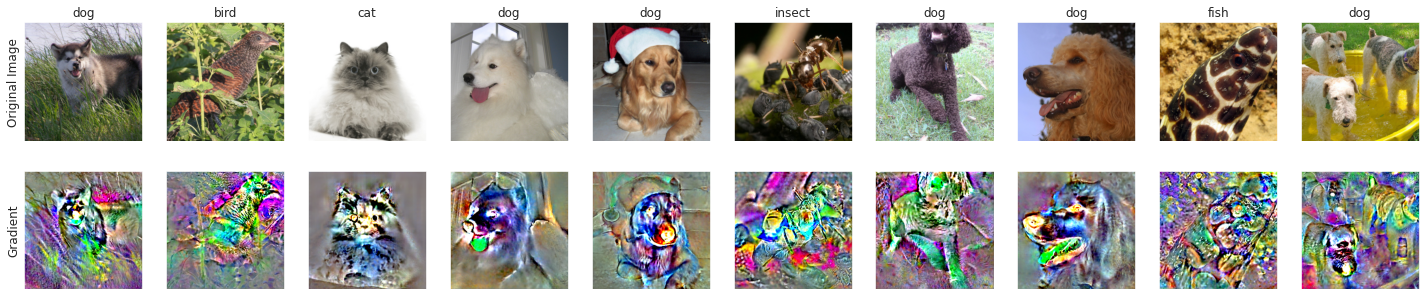

In [41]:
# Get gradient of the loss with respect to the input
grad_rob_RIN, _ = utils.get_gradient(robust_model, img_RIN, targ_RIN, normalization_function_RIN)

# Visualize gradient
num = DEFAULT_NUM
show_image_row([img_RIN[:num], utils.visualize_gradient(grad_rob_RIN)[:num]],
              ["Original Image", "Gradient"],
              tlist=[[label_map_RIN[int(t)] for t in targ_RIN], ["" for _ in targ_RIN]])

### VI.2 Feature Visualization

Another popular interpretability technique is known as feature visualization. Here, the goal is to find an input that maximizes a feature (a particular neuron in the deep network), instead of just trying to maximize the loss (as we did before with gradients).

You could now try to implement feature visualization yourself. For instance, the following function gives you, for specific inputs, the model's feature vector (the layer before the final linear classifier). 

In [42]:
# Getting the feature representation from the model
with torch.no_grad():
    feats_RIN = utils.get_features(robust_model, img_RIN, normalization_function_RIN)
    print(f"Dimensions of the feature vector: {feats_RIN.shape}")

Dimensions of the feature vector: torch.Size([20, 2048])


#### Implement a loss function to perform feature visualization

Fill in the skeleton below to create a feature visualization loss function. Our goal is to maximize the `feature_number` coordinate of the feature vector. Generally, if `im` is a batch of images, then values of `feature_number` can be different for every image in the batch (hence the use of `gather` in the following code).

In [43]:
# Feature visualization loss: Try to find an input that maximizes a specific feature

def feature_maximization_loss(mod, im, feature_number, normalization):
    # feature number is a vector with a feature index for every input in the batch
    # Get feature vector for inputs
    feature_vector = utils.get_features(mod, im, normalization)
    # select value for the respective feature for given image in the batch
    relevant_coordinate = torch.gather(feature_vector, 1, feature_number[:, None])
    # We want to maximize the `targ` coordinate of the feature vector for every input
    # DONE fill this line
    loss = torch.mean(relevant_coordinate)
    return loss

#### Visualize the results of feature visualization

You can then supply the `feature_maximization_loss` to the `custom_loss` argument input in `L2PGD`, and maximize it using the following snippet.

In [44]:
# Chose a feature to visualize
FEATURE_RIN = 314 # should be less than 2048

target_feature_RIN = FEATURE_RIN * torch.ones_like(targ_RIN)

In [45]:
# Maximize feature 
im_f_RIN = L2PGD(robust_model, img_RIN, target_feature_RIN, normalization_function_RIN,
                              step_size=5, Nsteps=20, eps=1000, 
                              custom_loss=feature_maximization_loss, 
                              targeted=False, use_tqdm=True)

Loss: 0.7097983956336975: 100%|██████████| 20/20 [00:10<00:00,  1.87it/s]


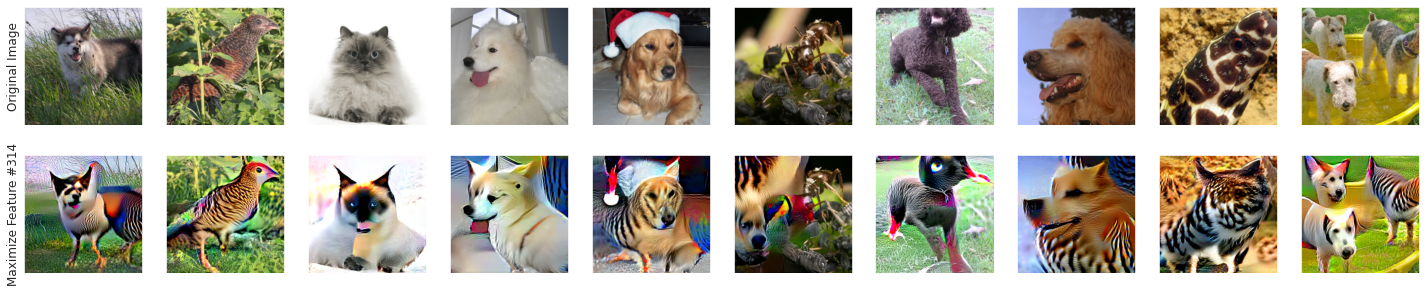

In [46]:
# Visualize results
num = DEFAULT_NUM
show_image_row([img_RIN[:num], im_f_RIN[:num]],
               ["Original Image", f"Maximize Feature #{FEATURE_RIN}"])

#### Try the same for a standard model

In [47]:
# Load image-label pair from ImageNet
img_IN, targ_IN = next(iter(test_loader_IN))

FEATURE_IN = 314 # remember that std_model has 512 features
target_feature_IN = FEATURE_IN * torch.ones_like(targ_IN)

im_f_IN = L2PGD(std_model, img_IN, target_feature_IN, normalization_function_IN,
                              step_size=5, Nsteps=20, eps=1000, 
                              custom_loss=feature_maximization_loss, 
                              targeted=False, use_tqdm=True)

Loss: 43.06394577026367: 100%|██████████| 20/20 [00:04<00:00,  4.56it/s]


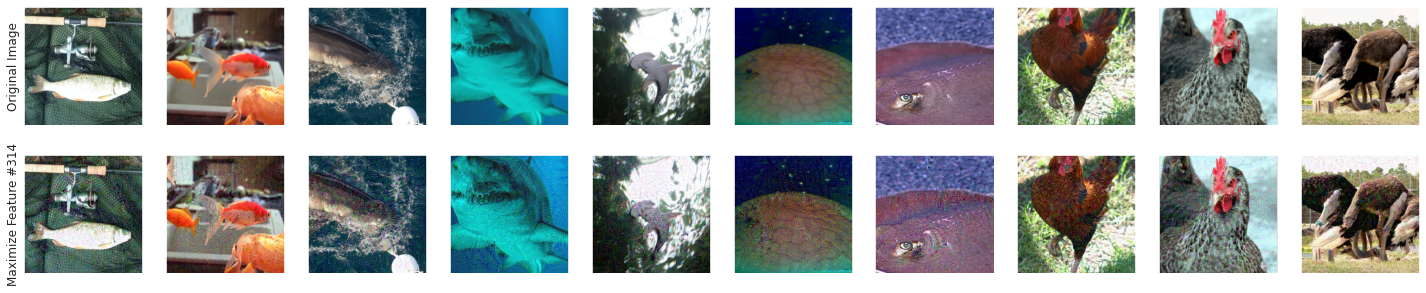

In [48]:
num = DEFAULT_NUM
show_image_row([img_IN[:num], im_f_IN[:num]],
               ["Original Image", f"Maximize Feature #{FEATURE_IN}"])

### VI.3 Try feature visualization for robust models starting from noise rather than images

What if we try feature visualization starting from noise?

In [49]:
# Create a "noise" image
noise_img_RIN = torch.clamp(torch.randn_like(img_RIN) + 0.5, 0, 1)

im_f_noise_RIN = L2PGD(robust_model, noise_img_RIN, target_feature_RIN, normalization_function_RIN,
                     step_size=5, Nsteps=200, eps=1000, 
                     custom_loss=feature_maximization_loss, 
                     targeted=False, use_tqdm=True)

Loss: 1.6744308471679688: 100%|██████████| 200/200 [01:46<00:00,  1.88it/s]


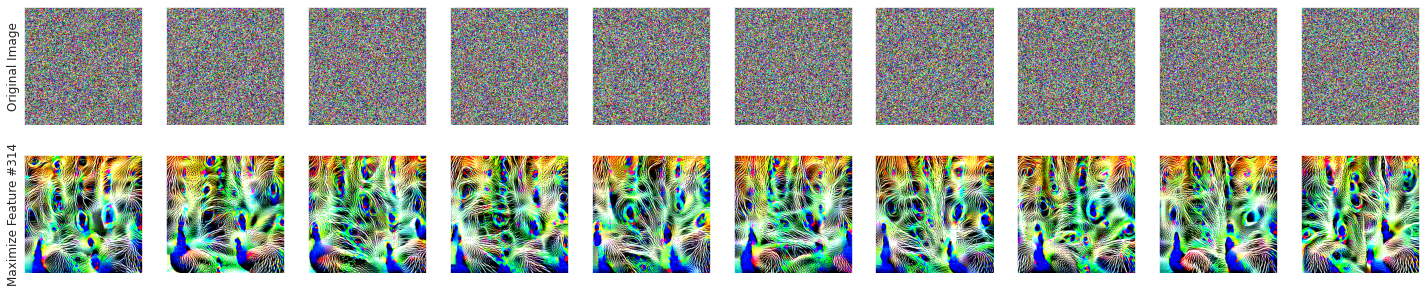

In [50]:
num = DEFAULT_NUM
show_image_row([noise_img_RIN[:num], im_f_noise_RIN[:num]],
                ["Original Image", f"Maximize Feature #{FEATURE_RIN}"])

# Exercise VII: Robust training

In Exercise II we trained a linear network to discern between cats and airplaines. We provided two functions: 
`train_loop` and `eval_loop` for standard training. It turns out that it suffices to add one line (or multiline)
of code to both functions (and remove one additional line from `eval_loop`) to obtain robust training loops. 

Fill in the missing code and train the `robust_linear_net`.

In [51]:
def adv_train_loop(model, loader, optimizer, criterion, epoch="-", normalization=None):
    acc_meter = AverageMeter()
    iterator = tqdm(iter(loader), total=len(loader))
    for data, target in iterator:        
        data, target = data.cuda(), target.cuda()
        model.train()
        # DONE fill the rest of code

        data = L2PGD(model, data, target, normalization,
                       step_size=0.5, Nsteps=20, 
                       eps=1.25, targeted=False, use_tqdm=False)
        
        optimizer.zero_grad()
        logits = utils.forward_pass(model, data, normalization)
        loss = criterion(logits, target)
        loss.backward()
        optimizer.step()
    
        ## END
        with torch.no_grad():
            model.eval()
            val = utils.accuracy(model, data, target, normalization)
            acc_meter.update(val, data.shape[0])
            
            iterator.set_description(f"Epoch: {epoch}, AdvTrain accuracy={acc_meter.avg:.2f}")
            iterator.refresh()
            
            
def adv_eval_loop(model, loader, epoch="-", normalization=None):
    acc_meter = AverageMeter()
    iterator = tqdm(iter(loader), total=len(loader))
    model.eval()
    # DONE - fill the rest of code
    for data, target in iterator:
        data, target = data.cuda(), target.cuda()

        data = L2PGD(model, data, target, normalization,
                   step_size=0.5, Nsteps=20, 
                   eps=1.25, targeted=False, use_tqdm=False)

        ## END
        val = utils.accuracy(model, data, target, normalization)
        acc_meter.update(val, data.shape[0])

        iterator.set_description(f"Epoch: {epoch}, ADV_TEST accuracy={acc_meter.avg:.2f}")
        iterator.refresh()

In [52]:
robust_linear_net = utils.Linear(Nfeatures=3*32*32, Nclasses=2).cuda()

train_model(robust_linear_net,
            train_loader_BIN,
            test_loader_BIN,
            adv_train_loop,
            adv_eval_loop,
            step_size = 0.001,
            epochs = 11,
            normalization=normalization_function_BIN
)

Epoch: 10, ADV_TEST accuracy=68.05: 100%|██████████| 20/20 [00:01<00:00, 15.96it/s]


Play with the `robust_linear_net`. Check if it has similar properties to the `robust_model`. Compare it to `std_linear_net`. Are the benefits of robust training visible for models as simple as linear models?

In [53]:
# Choose a target label for the attack.
TARGET_BIN = 1

print(f"Target class: {label_map_BIN[TARGET_BIN]}")

Target class: cat


In [54]:
# Load images from the Restricted ImageNet dataset
img_BIN, targ_BIN = next(iter(train_loader_BIN))

target_class_BIN = TARGET_BIN * torch.ones_like(targ_BIN)

# Create adversarial examples
adv_ex_BIN = L2PGD(robust_linear_net, img_BIN, target_class_BIN, normalization_function_BIN,
                       step_size=1, Nsteps=20, eps=15, targeted=True, use_tqdm=True)

# Evaluate model predictions
pred_label_BIN = utils.get_predictions(robust_linear_net, adv_ex_BIN, normalization_function_BIN)

Loss: 0.006880518980324268: 100%|██████████| 20/20 [00:00<00:00, 105.54it/s]


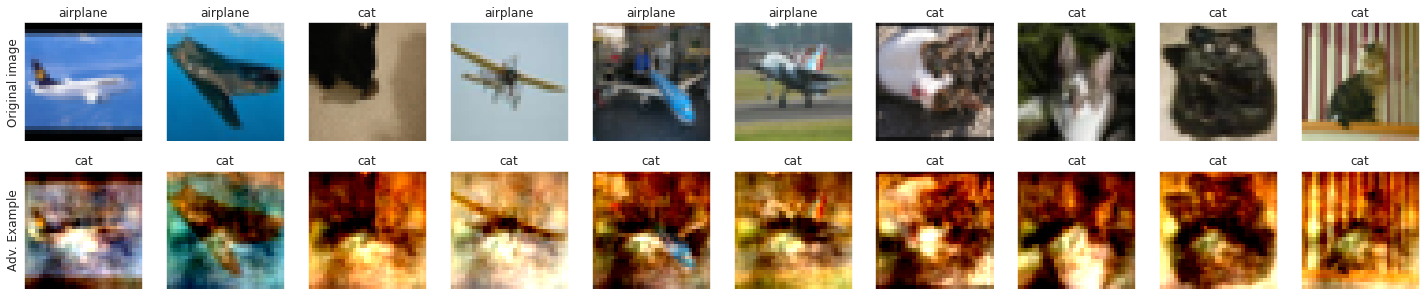

In [55]:
# Visualize adversarial examples
num = DEFAULT_NUM
show_image_row([img_BIN[:num], adv_ex_BIN[:num]], 
               ['Original image', 'Adv. Example'],
               tlist=[[label_map_BIN[int(t)] for t in label] \
                      for label in [targ_BIN, pred_label_BIN]])

# Exercise VIII: Backdoor attack and defense

Implement a simple backdoor attack - modify top left corner of each training image so that it's `1` if the target is `1` and `0` if the target is `0`. See if that affects the network trained in the standard way.

In [56]:
def backdoor_train_loop(model, loader, optimizer, criterion, epoch="-", normalization=None):
    acc_meter = AverageMeter()
    iterator = tqdm(iter(loader), total=len(loader))
    for data, target in iterator:        
        data, target = data.cuda(), target.cuda()
        model.train()
        # DONE fill the rest of code
        data = data.clone().detach()
        data[:,0,0,0] = target
        
        optimizer.zero_grad()
        logits = utils.forward_pass(model, data, normalization)
        loss = criterion(logits, target)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            model.eval()
            val = utils.accuracy(model, data, target, normalization)
            acc_meter.update(val, data.shape[0])
            
            iterator.set_description(f"Epoch: {epoch}, Backdoor Train accuracy={acc_meter.avg:.2f}")
            iterator.refresh()

In [57]:
backdoor_linear_net = utils.Linear(Nfeatures=3*32*32, Nclasses=2).cuda()

train_model(backdoor_linear_net,
            train_loader_BIN,
            test_loader_BIN,
            backdoor_train_loop,
            eval_loop,
            step_size = 0.001,
            epochs = 11,
            normalization=normalization_function_BIN
)

Epoch: 10, TEST accuracy=62.20: 100%|██████████| 20/20 [00:00<00:00, 31.99it/s]


We thus managed to fool the network trained in the standard way. Is robust training enough defense against the backdoor attack? Repeat the backdoor attack but use robust training this time.

In [58]:
# DONE - write the code
def adv_backdoor_train_loop(model, loader, optimizer, criterion, epoch="-", normalization=None):
    acc_meter = AverageMeter()
    iterator = tqdm(iter(loader), total=len(loader))
    for data, target in iterator:        
        data, target = data.cuda(), target.cuda()
        
        data = data.clone().detach()
        data[:,0,0,0] = target

        data = L2PGD(model, data, target, normalization,
                step_size=0.5, Nsteps=20, 
                eps=1.25, targeted=False, use_tqdm=False)
        
        model.train()
        optimizer.zero_grad()
        logits = utils.forward_pass(model, data, normalization)
        loss = criterion(logits, target)
        loss.backward()
        optimizer.step()
    
        with torch.no_grad():
            model.eval()
            val = utils.accuracy(model, data, target, normalization)
            acc_meter.update(val, data.shape[0])
            
            iterator.set_description(f"Epoch: {epoch}, Backdoor Adv Train accuracy={acc_meter.avg:.2f}")
            iterator.refresh()

In [59]:
adv_backdoor_linear_net = utils.Linear(Nfeatures=3*32*32, Nclasses=2).cuda()

train_model(adv_backdoor_linear_net,
            train_loader_BIN,
            test_loader_BIN,
            adv_backdoor_train_loop,
            eval_loop,
            step_size = 0.001,
            epochs = 11,
            normalization=normalization_function_BIN
)

Epoch: 10, TEST accuracy=78.60: 100%|██████████| 20/20 [00:00<00:00, 32.35it/s]


In [60]:
eval_loop(adv_backdoor_linear_net, train_loader_BIN, normalization=normalization_function_BIN)

Epoch: -, TEST accuracy=77.52: 100%|██████████| 100/100 [00:03<00:00, 32.82it/s]


from :http://phdopen.mimuw.edu.pl/index.php?page=z20w1

# 新段落